In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torchaudio
from transformers import MarianMTModel, MarianTokenizer
import audioread # Explicitly import audioread
import soundfile as sf


In [ ]:
audio_path = '/content/drive/MyDrive/Colab Notebooks/harvard.wav'
y, sr = librosa.load(audio_path)

# Extract features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

print(f"Sampling Rate: {sr} Hz")



Sampling Rate: 22050 Hz


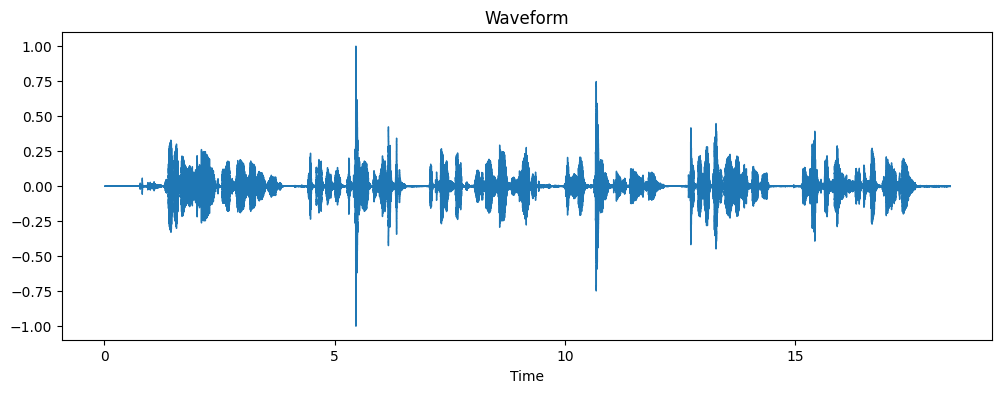

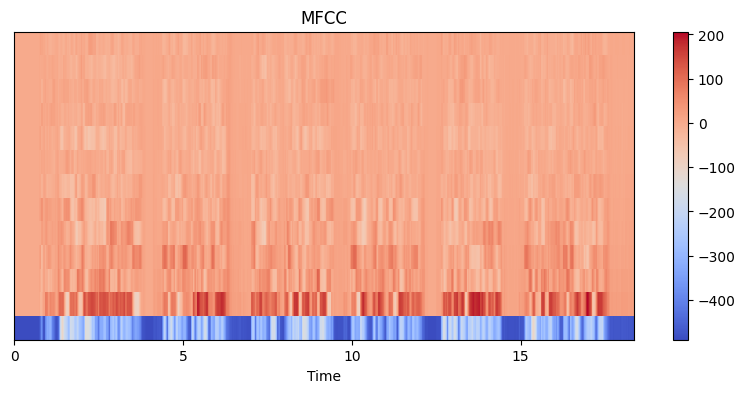

In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()


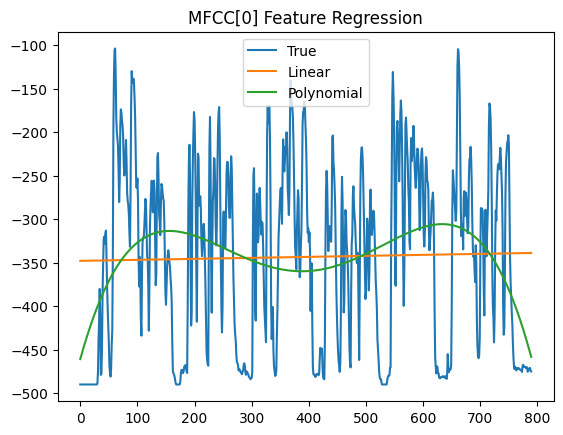

In [ ]:
X = np.arange(mfccs.shape[1] - 1).reshape(-1, 1)
y_reg = mfccs[0, 1:]

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X, y_reg)

# Polynomial Regression
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y_reg)

# Plot
plt.plot(X, y_reg, label='True')
plt.plot(X, lin_reg.predict(X), label='Linear')
plt.plot(X, poly_reg.predict(X_poly), label='Polynomial')
plt.legend()
plt.title("MFCC[0] Feature Regression")
plt.show()


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

# Sample data: let's say we have 100 MFCC samples
X_train = torch.tensor(mfccs[:, :100].T, dtype=torch.float32)
y_train = torch.randint(0, 10, (100,), dtype=torch.long)

model = SimpleNN(13, 64, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 2.3387
Epoch 10, Loss: 2.3265
Epoch 20, Loss: 2.2711
Epoch 30, Loss: 2.2706
Epoch 40, Loss: 2.2700
Epoch 50, Loss: 2.2697
Epoch 60, Loss: 2.2694
Epoch 70, Loss: 2.2690
Epoch 80, Loss: 2.2692
Epoch 90, Loss: 2.2690


In [ ]:
src_text = "Hello, how are you?"
model_name = 'Helsinki-NLP/opus-mt-en-fr'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Tokenize and translate
inputs = tokenizer(src_text, return_tensors="pt", padding=True)
translated = model.generate(**inputs)
translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
print("Translated Text:", translated_text)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Translated Text: Bonjour, comment allez-vous ?


In [ ]:
!pip install SpeechRecognition


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 37.2 MB/s eta 0:00:00


In [ ]:
import speech_recognition as sr

recognizer = sr.Recognizer()
with sr.AudioFile(audio_path) as source:
    audio = recognizer.record(source)
    text = recognizer.recognize_google(audio)
    print("Recognized:", text)

# Translate recognized text
inputs = tokenizer(text, return_tensors="pt")
translated = model.generate(**inputs)
translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
print("Translated:", translated_text)


Recognized: the stale smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al pastor are my favorite a zestful food is the hot cross bun
Translated: l'odeur stagnante de la vieille bière s'attarde il faut de la chaleur pour faire ressortir l'odeur d'une trempe froide restaure la santé et zeste un goût de cornichon de sel fin avec tacos de jambon al pasteur sont mes préférés un zestful nourriture est le pain de croix chaud


In [ ]:
!pip install jiwer evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.2 MB/s eta 0:00:00


In [ ]:
from jiwer import wer, cer
import evaluate

recognized_text = "the stale smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al pastor are my favorite a zestful food is the hot cross bun"
ground_truth_text = "the stale smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al pastor are my favorite a zestful food is the hot cross bun"

translated_text = "l'odeur stagnante de la vieille bière s'attarde il faut de la chaleur pour faire ressortir l'odeur d'une trempe froide restaure la santé et zeste un goût de cornichon de sel fin avec tacos de jambon al pasteur sont mes préférés un zestful nourriture est le pain de croix chaud"
reference_translation = "l'odeur rance de la vieille bière persiste il faut de la chaleur pour faire ressortir l'odeur une trempette froide restaure la santé et le zeste un cornichon salé a bon goût avec du jambon les tacos al pastor sont mes préférés un plat plein de peps est le pain chaud croisé"

# 1. Evaluate ASR
asr_wer = wer(ground_truth_text, recognized_text)
asr_cer = cer(ground_truth_text, recognized_text)
print(f"ASR - WER: {asr_wer:.2f}, CER: {asr_cer:.2f}")

# 2. Evaluate Translation
bleu = evaluate.load("bleu")
bleu_score = bleu.compute(predictions=[translated_text], references=[[reference_translation]])
print(f"Translation - BLEU: {bleu_score['bleu']:.2f}")


ASR - WER: 0.00, CER: 0.00


Translation - BLEU: 0.37
